## Two-pion photo production

### Kinematic ranges of the variables

In [1]:
const mπ = 0.140; const mπ2 = mπ^2
const mp = 0.938; const mp2 = mp^2
const mΔ = 1.232; const mΔ2 = mΔ^2
#
const s = mΔ^2
const s0 = (9)^2
#
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
const tpm = (0+mπ2-(s0+0-mp2)*(s0+mπ2-s)/(2s0)) .+ (sqrt(λ(s0,0,mp2)*λ(s0,mπ2,s))/(2s0)) .* [-1,1];

### Write all four vectors in terms of 5 variables in GJ frame:
 - $t$ is a ransfered momentum, difference between photon and the pion
 - $cos\theta$, $\phi$ are sperical angles in the GJ frame
 - $s_0$ and $s$ are invariant mass of the whole system (photon-proton) and $\pi p$ invariant mass (Delta).
 These variables are fixed.

In [2]:
function all_quantities(t,cosθ,ϕ)
    #
    u = s+mπ2+mp2-t-s0
    #
    p2 = sqrt(λ(s,mπ2,mp2)/(4s)); k1 = p2
    p1 = sqrt(λ(s,  t,mp2)/(4s))
    k2 = sqrt(λ(s0, s,mπ2)/(4s))
    q  = sqrt(λ(u,  s,  0)/(4s))
    #
    E1p = sqrt(mp2+p1^2)
    E2p = sqrt(mp2+p2^2)
    E1k = sqrt(mπ2+k1^2)
    E2k = sqrt(mπ2+k2^2)
    Eq  = q
    #
    cosϵ = (s0-mp2  -2*E1p*Eq   )/(2*p1*q )
    cosδ = (mp2+mπ2-2*E1p*E2k-u)/(2*p1*k2)
    sinϵ = sqrt(1-cosϵ^2); sinδ = sqrt(1-cosδ^2)
    #
    _p1 = [E1p,0,0,p1]
    _q  = [Eq , -q*sinϵ, 0.0,  -q*cosϵ]
    _k2 = [E2k,-k2*sinδ, 0.0, -k2*cosδ]
    sinθ = sqrt(1-cosθ^2)
    _p2 = [E2p, sinθ*cos(ϕ), sinθ*sin(ϕ), cosθ]; _p2[2:end] .*= p2
    _k1 = [E1k, 0.0, 0.0, 0.0]; _k1[2:end] .-= _p2[2:end]
    #
    vectors = Dict(:q=>_q, :p1=>_p1,:p2=>_p2,:k1=>_k1,:k2=>_k2)
    return vectors
end

all_quantities (generic function with 1 method)

In [3]:
println("Energy-momentum conservation, the sum should be zero")
let v = all_quantities(-0.001,0.1,0.3)
    v[:q]+v[:p1] - (v[:k1]+v[:k2]+v[:p2])
end

Energy-momentum conservation, the sum should be zero


4-element Array{Float64,1}:
  0.0                   
 -1.5498713423767185e-13
  0.0                   
  1.4210854715202004e-14

### Rand - t intervals
To obtain "more physical" physical picture, the $t'$ distribution is generated according to exponent,
$$
\frac{\mathrm{d}N}{\mathrm{d}t'} = e^{-\alpha t'},\text{ where } t' = |t|-|t|_{\text{min}} 
$$
with $\alpha = 10\,$GeV$^2$.

In [4]:
function randtprime()
    tprimemax = 1.0 # GeV 
    α = 10.0
    y = rand()
    return -log(1-y+y*exp(-α*tprimemax))/α
end
#
randt() = tpm[2]-randtprime()

randt (generic function with 1 method)

In [5]:
using Plots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

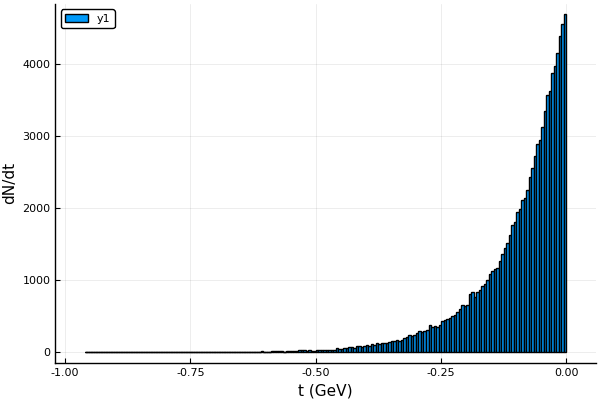

In [6]:
histogram([randt() for _ = 1:1e5], ylab="dN/dt", xlab = "t (GeV)")

In [7]:
savefig("dNdt.pdf")

In [8]:
const Nd = 100000
const pseudodata = [[randt() 2*rand()-1 π*(2*rand()-1)] for _ = 1:Nd];
const vpseudodata = vcat(pseudodata...);

In [9]:
using DelimitedFiles

In [10]:
let name = "pseudodata_1e5_s0_s_t_cosT_phi.txt"
    isfile(name) && return
    writedlm(name, vcat([[s0 s vpseudodata[i,:]...] for i in 1:Int(Nd)]...))
end

In [11]:
using LinearAlgebra
invmasssq(v) = v[1]^2-norm(v[2:4])^2

invmasssq (generic function with 1 method)

In [12]:
function invariant_masses(t,cosθ,ϕ)
    v = all_quantities(t,cosθ,ϕ)
    return Dict(:sPiPi=>invmasssq(v[:k1]+v[:k2]),
                :sPi1P=>invmasssq(v[:p2]+v[:k1]),
                :sPi2P=>invmasssq(v[:p2]+v[:k2]))
end

invariant_masses (generic function with 1 method)

In [13]:
function zvar(s,t,ms)
    z = (2s*(t-ms[1]-ms[3])+(s+ms[1]-ms[2])*(s+ms[3]-ms[4]))/sqrt(λ(s,ms[1],ms[2])*λ(s,ms[3],ms[4]))
end
function variables(t,cosθ,ϕ)
    v = all_quantities(t,cosθ,ϕ)
    # t-channel
    Msqt = s
    zt = zvar(Msqt,
              invmasssq(v[:p2]-v[:p1]),
              [mp2,invmasssq(v[:q]-v[:k2]),mp2,mπ2])
    # s-channel
    Msqs = s
    zs = zvar(Msqs,
              invmasssq(v[:k1]+v[:k2]),
              [s0,mπ2,mp2,mπ2])
    # u-channel
    Msqu = invmasssq(v[:p1]-v[:k2])
    zu = zvar(Msqu,
              invmasssq(v[:k1]+v[:k2]),
              [mp2,mπ2,invmasssq(v[:q]-v[:p2]),mπ2])
    #
    return Dict(:t=>(Msqt,zt), :s=>(Msqs,zs), :u=>(Msqu,zu))
end

variables (generic function with 1 method)

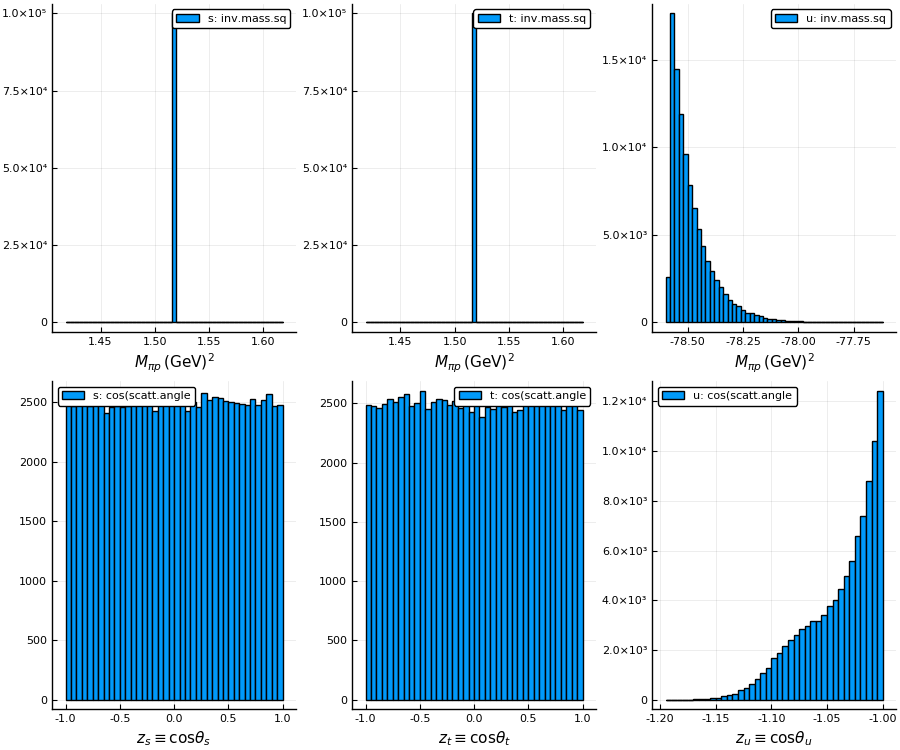

In [14]:
let
    Msq_z = map(x->variables(x...), pseudodata)
    plot(layout = grid(2,3), size=(900,750))
    for (i,ch) in enumerate([:s, :t, :u])
        histogram!(map(x->x[ch][1],Msq_z), subplot=i, lab = "$(string(ch)): inv.mass.sq",
            bins=((i==3) ? 50 : LinRange(s-0.1,s+0.1,50)),
            xlab=L"M_{\pi p}\,(\mathrm{GeV})^2")
        histogram!(map(x->x[ch][2],Msq_z), subplot=3+i, lab = "$(string(ch)): cos(scatt.angle", bins=50,
            xlab=LaTeXString("\$z_$(string(ch))\\equiv \\cos\\theta_$(string(ch))\$"))
    end
    plot!()
end

In [15]:
savefig("variable_ranges.pdf")

### Check: $s$-channel vs $t$-channel scattering angle

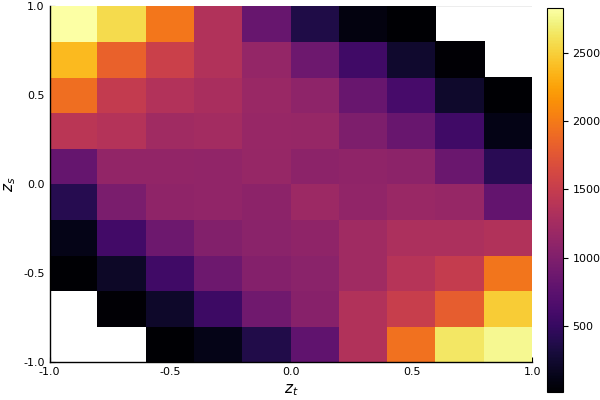

In [16]:
let
    Msq_z = map(x->variables(x...), pseudodata)
    histogram2d(map(x->x[:t][2],Msq_z), map(x->x[:s][2],Msq_z), xlab=L"z_t", ylab=L"z_s")
end